# OCEAN to MBTI


## Correlation matrix
[Статья](https://reunir.unir.net/bitstream/handle/123456789/9799/ijimai20142_7_4_pdf_92105.pdf?sequence=1&isAllowed=y)

| | Extraversion | Openness | Agreeableness | Conscientiousness | Neuroticism |
| --- | ------------ | -------- | ------------- | ----------------- | ----------- |
| E-I | -0.74 | 0.03 | -0.03 | 0.08 | 0.16 |
| S-N | 0.10 | 0.72 | 0.04 | -0.15 | -0.06 |
| T-F | 0.19 | 0.02 | 0.44 | -0.15 | 0.06 |
| J-P | 0.15 | 0.30 | -0.06 | -0.49 | 0.11 |

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
correlation_matrix = pd.DataFrame({
    "E-I": np.array([-0.74, 0.03, -0.03, 0.08, 0.16]),
    "S-N": np.array([0.10, 0.72, 0.04, -0.15, -0.06]),
    "T-F": np.array([0.19, 0.02, 0.44, -0.15, 0.06]),
    "J-P": np.array([0.15, 0.30, -0.06, -0.49, 0.11]),
}, index = ['Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness', 'Neuroticism'])

In [ ]:
correlation_matrix.T

In [ ]:
def ocean_to_mbti(ocean_vector):
    """
    Конвертирует OCEAN-представление в MBTI на основе корреляционной матрицы.
    :param ocean_vector: np.array с пятью значениями OCEAN в порядке [E, O, A, C, N]. Значение от 0 до 1 (степень выраженности черты)
    :return: строка с типом MBTI
    """
    mbti_vector = {}
    
    # Рассчитываем значение каждой шкалы MBTI
    for scale, weights in correlation_matrix.items():
        mbti_vector[scale] = np.dot(ocean_vector, weights)
    
    mbti_type = (
        "E" if mbti_vector["E-I"] > 0.5 else "I",
        "N" if mbti_vector["S-N"] > 0.5 else "S",
        "F" if mbti_vector["T-F"] > 0.5 else "T",
        "P" if mbti_vector["J-P"] > 0.5 else "J",
    )
    
    return "".join(mbti_type)

In [ ]:
ocean_vector = np.array([0.6, 0.7, 0.2, 0.1, 0.3])
mbti_type = ocean_to_mbti(ocean_vector)
print("Тип личности MBTI:", mbti_type)

In [22]:
import pickle
import pandas as pd
import numpy as np
import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from itertools import product

In [23]:
candidates_video_emb = []
for i in os.listdir('data/validation/video_embeddings/'):
    emb = np.load(f'data/validation/video_embeddings/{i}')
    candidates_video_emb.append(emb[0])
candidates_video_emb = np.array(candidates_video_emb)

candidates_text_emb = []
for i in os.listdir('data/validation/text_embeddings/'):
    emb = np.load(f'data/validation/text_embeddings/{i}')
    candidates_text_emb.append(emb)
candidates_text_emb = np.array(candidates_text_emb)

vacancies_emb = []
for i in os.listdir('data/embeddings/vacancies/embeddings'):
    emb = np.load(f'data/embeddings/vacancies/embeddings/{i}')
    vacancies_emb.append(emb)
vacancies_emb = np.array(vacancies_emb)

types_emb = np.load('data/embeddings/OCEAN_embeddings.npy')

vacancies_data = pd.read_csv('data/tables/vacancies.csv')
types_data = pd.read_csv('data/tables/personality.csv')
with open('data/train/transcription.pkl', 'rb') as file:
    candidates_data = pickle.load(file)

with open('data/test_submit.pkl', 'rb') as file:
    submit_data = pickle.load(file)

In [29]:
pd.read_csv('data/tables/vacancies.csv')

,name,description,salary,skill,embedding_id
0,Flutter Developer,We are looking for hire experts flutter develo...,"73091,34050",NaN,NaN
1,Django Developer,PYTHON/DJANGO (Developer/Lead) - Job Code(PDJ ...,"57798,25463",NaN,NaN
2,Machine Learning,"Data Scientist (Contractor)\n\nBangalore, IN\n...","36135,52345",NaN,NaN
3,iOS Developer,JOB DESCRIPTION:\n\nStrong framework outside o...,"84821,64731",NaN,NaN
4,Full Stack Developer,job responsibility full stack engineer – react...,"15427,50861",NaN,NaN
...,...,...,...,...,...
2272,Backend Developer,Job Summary\nPublished on : 26 days ago\nVacan...,"14192,45557",NaN,NaN
2273,Full Stack Developer,business entity cisco umbrella focus cloud-bas...,"19966,87595",NaN,NaN
2274,Network Administrator,Urgently reqd in a college in Mohali\nNetwork ...,"31927,40154",NaN,NaN
2275,Machine Learning,Key Responsibilities: Team leads for small or ...,"16280,73342",NaN,NaN


In [6]:
candidates_video_emb_norm = candidates_video_emb / np.linalg.norm(candidates_video_emb, axis=1, keepdims=True)
candidates_text_emb_norm = candidates_text_emb / np.linalg.norm(candidates_text_emb, axis=1, keepdims=True)
types_emb_norm = types_emb / np.linalg.norm(types_emb, axis=1, keepdims=True)

candidates_emb = (candidates_video_emb_norm + candidates_text_emb_norm) / 2
similarity_matrix = cosine_similarity(candidates_emb, types_emb_norm)
similarity_matrix = (similarity_matrix + 1) / 2

In [7]:
similarity_matrix

array([[0.56522655, 0.5220037 , 0.500856  , 0.51264745, 0.5527435 ],
       [0.5313334 , 0.47418842, 0.5009375 , 0.48928064, 0.49509314],
       [0.47933343, 0.46106046, 0.49067193, 0.47807848, 0.46027115],
       ...,
       [0.5267535 , 0.5058971 , 0.5730923 , 0.55395013, 0.50574464],
       [0.52007735, 0.49479404, 0.5255972 , 0.5247809 , 0.5139392 ],
       [0.6173902 , 0.5817775 , 0.57775104, 0.5792599 , 0.5918907 ]],
      dtype=float32)

In [8]:
similarity_matrix.min(), similarity_matrix.max()

(0.4043529, 0.65945077)

(array([409., 225.,  17.,  12.,  24., 182., 313., 261.,  32., 525.]),
 array([ 0. ,  3.1,  6.2,  9.3, 12.4, 15.5, 18.6, 21.7, 24.8, 27.9, 31. ]),
 <BarContainer object of 10 artists>)

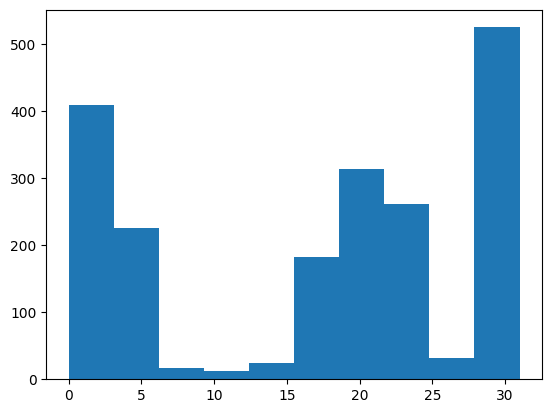

In [ ]:
all_combinations = list(product([0, 1], repeat=5))
indices = np.arange(len(all_combinations))

similarity_matrix = similarity_matrix > 0.5
class_vector = []

for i in range(len(similarity_matrix)):
    for class_, j in enumerate(all_combinations):
        if all(similarity_matrix[i] == j):
            class_vector.append(class_)

plt.hist(class_vector)